In [1]:
# Imports and Setup
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # Using Agg backend for matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# Setting style for seaborn
sns.set(style='whitegrid')

# Just a note: using warnings filter to help ensure that future users won't be annoyed by excessive warnings.

In [2]:
# Load the dataset
data_path = 'slope_stability_dataset.csv'
df = pd.read_csv(data_path, encoding='utf-8', delimiter=',')

# Display the first few rows of the dataset
df.head()

,Unit Weight (kN/m³),Cohesion (kPa),Internal Friction Angle (°),Slope Angle (°),Slope Height (m),Pore Water Pressure Ratio,Reinforcement Type,Reinforcement Numeric,Factor of Safety (FS)
0,18.745401,21.813837,38.249958,41.907228,18.451042,0.847237,Drainage,3,2.613692
1,24.507143,19.981044,24.612800,32.964623,9.266800,0.494517,Geosynthetics,2,2.241626
2,22.319939,12.926926,28.665992,58.224926,10.686165,0.195466,Retaining Wall,0,1.568244
3,20.986585,32.327000,36.582016,20.948923,13.130201,0.736642,Drainage,3,3.000000
4,16.560186,26.448087,32.052234,39.392821,14.164400,0.418678,Soil Nailing,1,3.000000


In [3]:
# Check for missing values and basic information
print('Missing values in each column:')
print(df.isnull().sum())

# Converting data types if necessary (for this exercise our data appears as expected)
print('\nData types of the columns:')
print(df.dtypes)

Missing values in each column:
Unit Weight (kN/m³)            0
Cohesion (kPa)                 0
Internal Friction Angle (°)    0
Slope Angle (°)                0
Slope Height (m)               0
Pore Water Pressure Ratio      0
Reinforcement Type             0
Reinforcement Numeric          0
Factor of Safety (FS)          0
dtype: int64

Data types of the columns:
Unit Weight (kN/m³)            float64
Cohesion (kPa)                 float64
Internal Friction Angle (°)    float64
Slope Angle (°)                float64
Slope Height (m)               float64
Pore Water Pressure Ratio      float64
Reinforcement Type              object
Reinforcement Numeric            int64
Factor of Safety (FS)          float64
dtype: object


In [4]:
# Generate descriptive statistics
df.describe()

,Unit Weight (kN/m³),Cohesion (kPa),Internal Friction Angle (°),Slope Angle (°),Slope Height (m),Pore Water Pressure Ratio,Reinforcement Numeric,Factor of Safety (FS)
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,19.941596,27.703844,32.501260,34.935669,27.358871,0.503145,1.494300,2.545083
std,2.876301,13.018255,7.169344,14.449730,13.017788,0.288341,1.120399,0.659996
min,15.000116,5.007099,20.001203,10.000277,5.000753,0.000008,0.000000,0.500000
25%,17.463289,16.427561,26.343698,22.342862,15.992250,0.256956,0.000000,2.125824
50%,19.925286,27.765355,32.551702,35.001512,27.217274,0.506090,1.000000,3.000000
75%,22.400063,39.041565,38.616846,47.355813,38.771467,0.753446,3.000000,3.000000
max,24.997177,49.996617,44.997524,59.989469,49.998747,0.999940,3.000000,3.000000


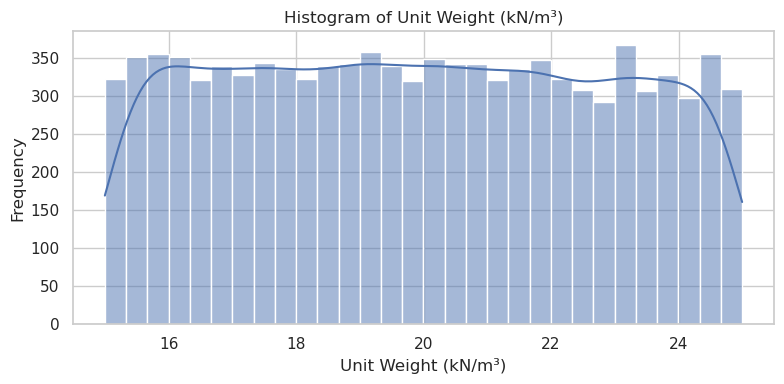

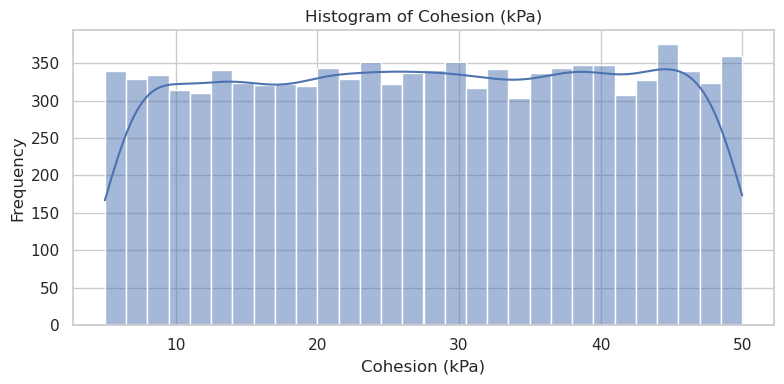

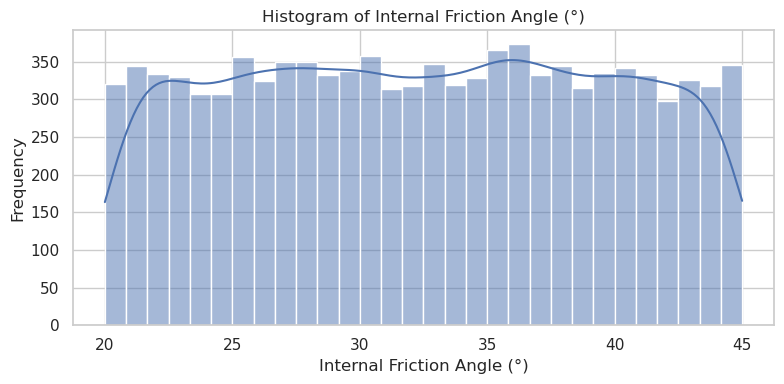

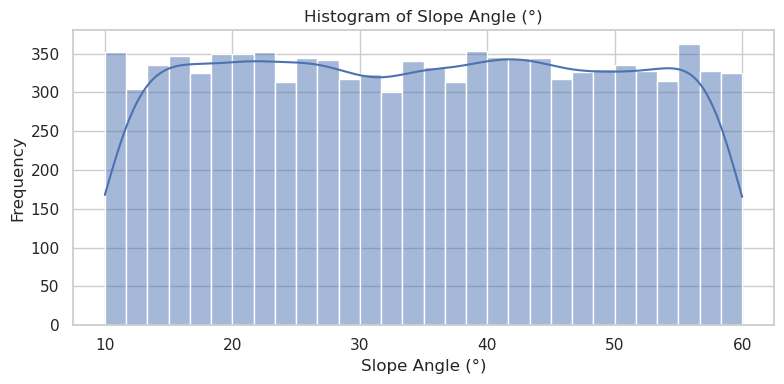

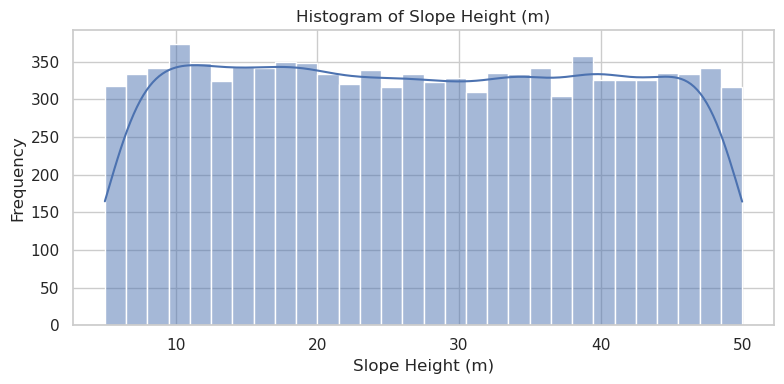

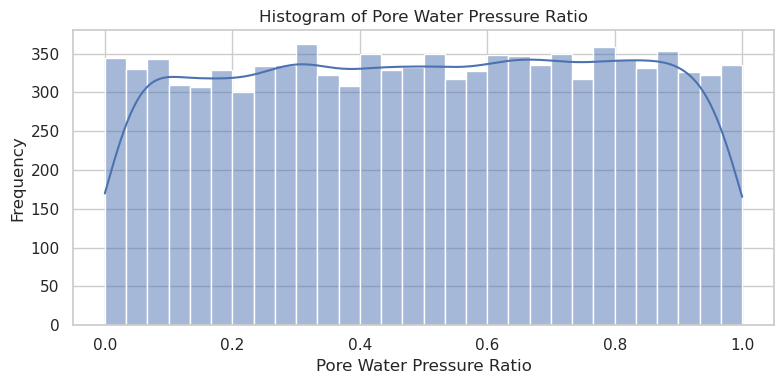

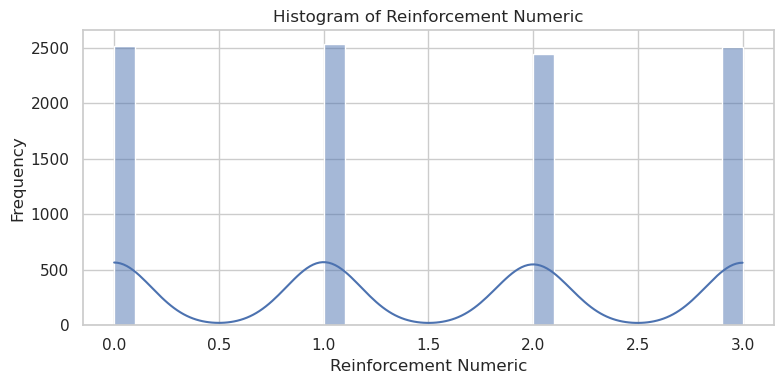

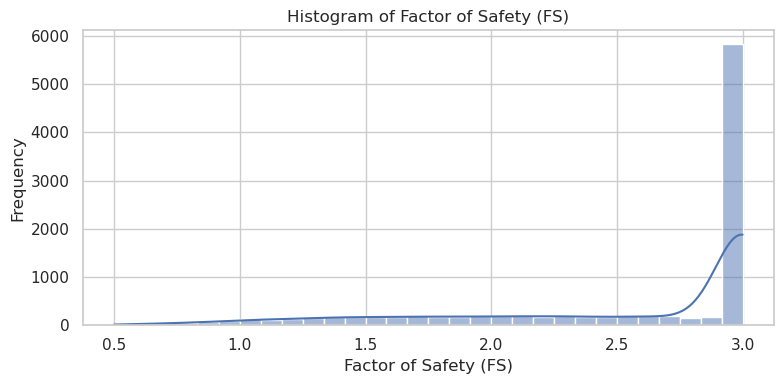

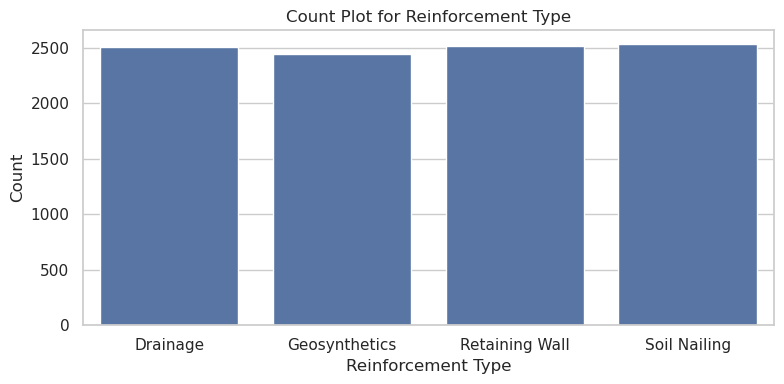

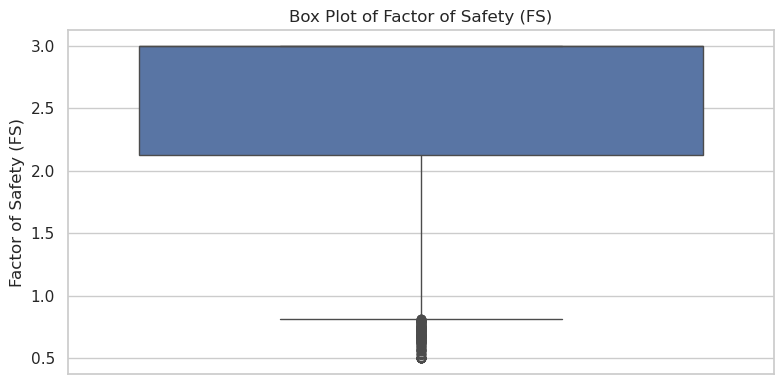

In [5]:
# Histogram for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Count plot for Reinforcement Type (a pie chart alternative)
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Reinforcement Type')
plt.title('Count Plot for Reinforcement Type')
plt.xlabel('Reinforcement Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Box plot for Factor of Safety (FS) which is critical in our analysis
plt.figure(figsize=(8, 4))
sns.boxplot(y=df['Factor of Safety (FS)'])
plt.title('Box Plot of Factor of Safety (FS)')
plt.ylabel('Factor of Safety (FS)')
plt.tight_layout()
plt.show()

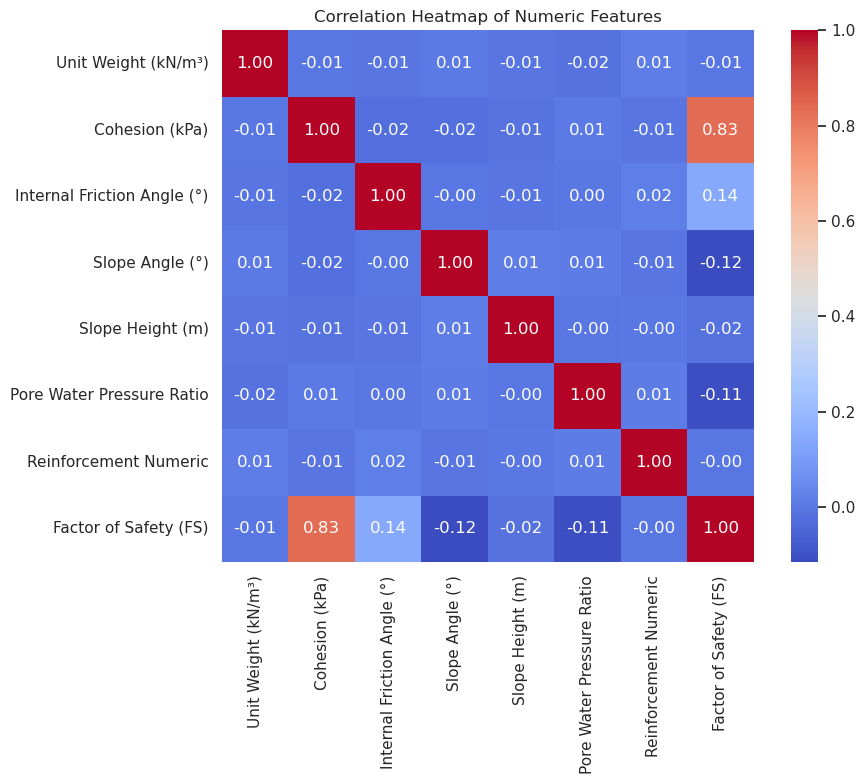

In [6]:
# Reduce dataframe to numeric columns and compute correlations
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', square=True, fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric features to generate a correlation heatmap.')

In [7]:
# Prepare data for regression
# We exclude 'Factor of Safety (FS)' as our target variable
target_column = 'Factor of Safety (FS)'

# For features, we drop the target column; if Reinforcement Type is categorical, we perform one-hot encoding
features = df.drop(columns=[target_column])
features = pd.get_dummies(features, columns=['Reinforcement Type'], drop_first=True)

X = features
y = df[target_column]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'R² Score: {r2:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')

R² Score: 0.996
Mean Absolute Error: 0.023


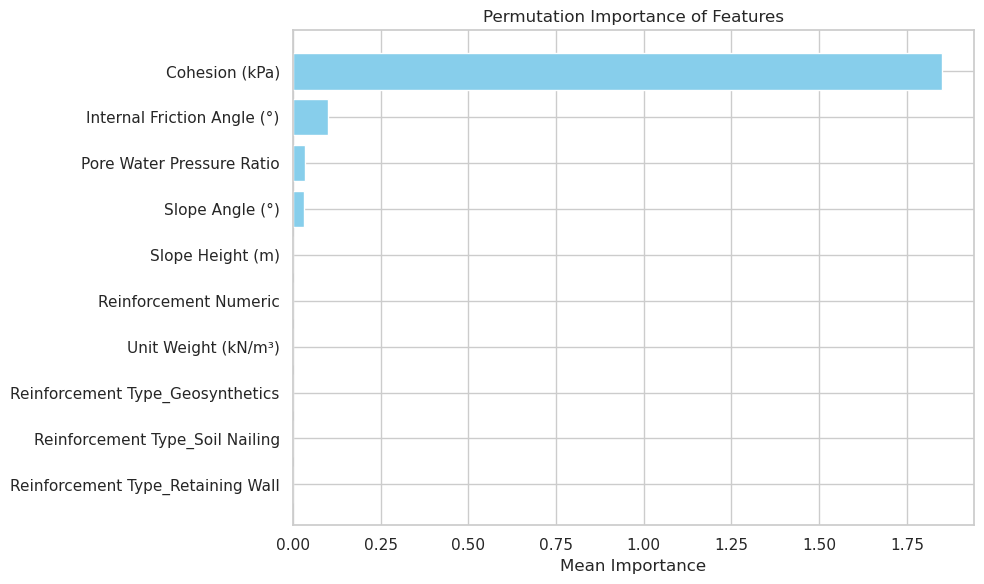

In [8]:
# Compute permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for visualization
feature_names = X_test.columns
importances_df = pd.DataFrame({'feature': feature_names, 'importance': perm_importance.importances_mean})
importances_df = importances_df.sort_values(by='importance', ascending=True)

# Plot permutation importance
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'], importances_df['importance'], color='skyblue')
plt.xlabel('Mean Importance')
plt.title('Permutation Importance of Features')
plt.tight_layout()
plt.show()

In [9]:
# 1. Install and Import
try:
    import xgboost as xgb
except ImportError:
    print("Installing XGBoost...")
    !pip install xgboost
    import xgboost as xgb

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 2. Safety Check: Ensure training data is in memory
try:
    X_train, y_train, X_test, y_test
except NameError:
    print("Error: X_train or y_train not found. Please run your data splitting cells first!")
else:
    # 3. Initialize and Train XGBoost
    xgb_model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )
    
    xgb_model.fit(X_train, y_train)

    # 4. Make Predictions
    y_pred_xgb = xgb_model.predict(X_test)

    # 5. Calculate Metrics (Using manual sqrt to avoid the 'squared' parameter error)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

    print(f"--- XGBoost Results ---")
    print(f"R2 Score: {r2_xgb:.4f}")
    print(f"MAE: {mae_xgb:.4f}")
    print(f"RMSE: {rmse_xgb:.4f}")

--- XGBoost Results ---
R2 Score: 0.9976
MAE: 0.0217
RMSE: 0.0320


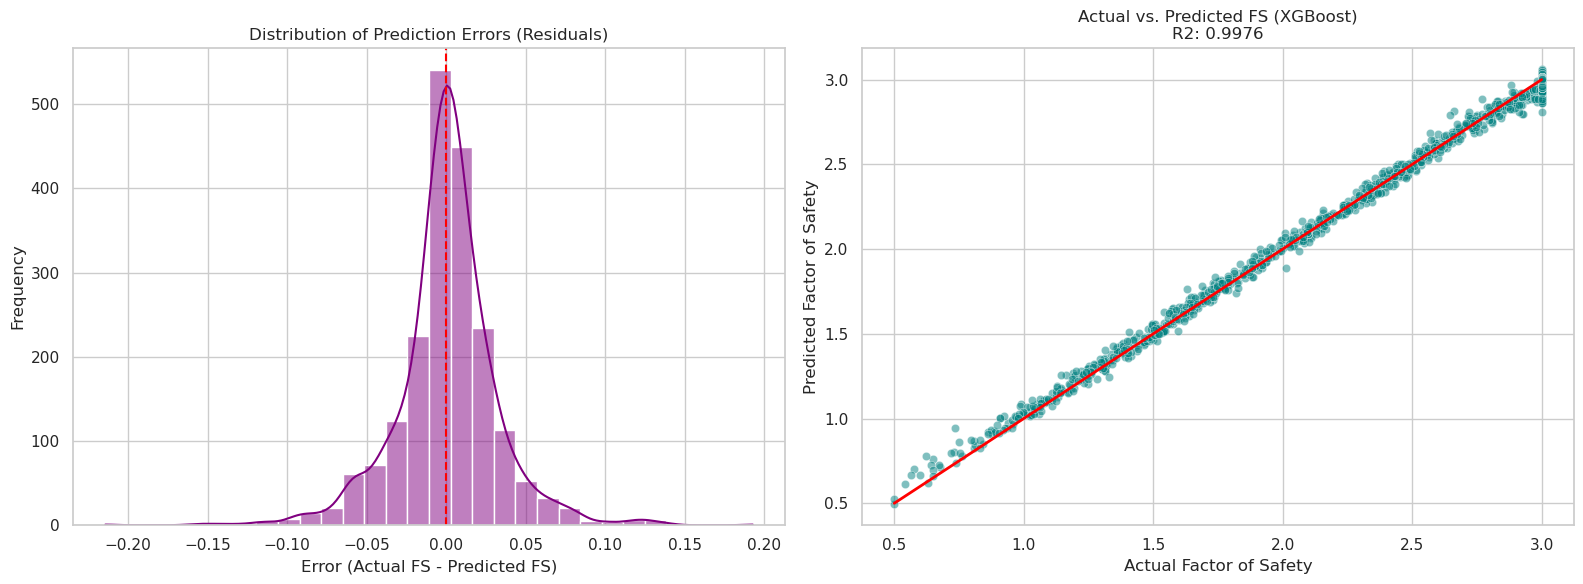

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate Residuals (Errors)
residuals = y_test - y_pred_xgb

# 2. Create the Visualizations
plt.figure(figsize=(16, 6))

# Subplot 1: Distribution of Errors (Histogram)
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Error (Actual FS - Predicted FS)")
plt.ylabel("Frequency")

# Subplot 2: Actual vs. Predicted Scatter Plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title(f"Actual vs. Predicted FS (XGBoost)\nR2: {r2_xgb:.4f}")
plt.xlabel("Actual Factor of Safety")
plt.ylabel("Predicted Factor of Safety")

plt.tight_layout()
plt.show()

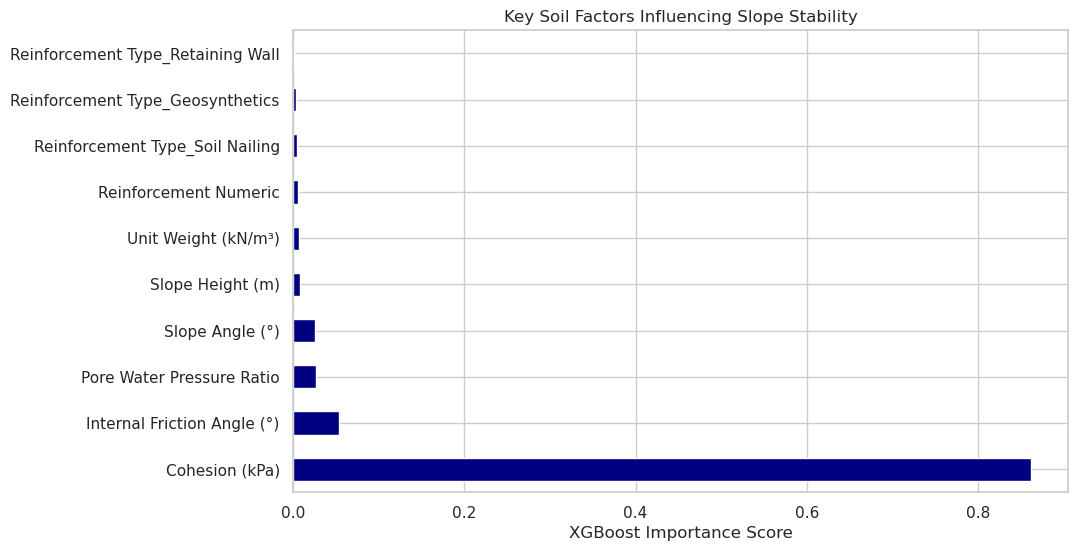

In [11]:
plt.figure(figsize=(10, 6))
# Get importance scores
feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='navy')
plt.title("Key Soil Factors Influencing Slope Stability")
plt.xlabel("XGBoost Importance Score")
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Calculate metrics for Random Forest
# (Assuming 'rf' is your trained Random Forest model from previous cells)
y_pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# 2. Calculate metrics for XGBoost 
# (Using 'y_pred_xgb' and metrics already calculated in your XGBoost cell)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
# Note: r2_xgb and mae_xgb were already defined in your previous code block

# 3. Construct the Summary DataFrame
performance_dict = {
    'Metric': ['R² Score', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)'],
    'Random Forest': [f"{r2_rf:.4f}", f"{mae_rf:.4f}", f"{rmse_rf:.4f}"],
    'XGBoost': [f"{r2_xgb:.4f}", f"{mae_xgb:.4f}", f"{rmse_xgb:.4f}"]
}

performance_df = pd.DataFrame(performance_dict)

# 4. Display the table
print("Comparison of Model Performance:")
display(performance_df)

Comparison of Model Performance:


,Metric,Random Forest,XGBoost
0,R² Score,0.9959,0.9976
1,Mean Absolute Error (MAE),0.0225,0.0217
2,Root Mean Squared Error (RMSE),0.0416,0.0320
